## Многорукие бандиты. Контекстные бандиты.


<img src="https://miro.medium.com/max/1146/1*XU13pI_KETfwIJnc8gWS7w.png">
Названия метода пошло от «одноруких бандитов» — игровых автоматов в казино с рычагом, за который можно потянуть и получить выигрыш. Представьте, что вы находитесь в зале с десятком таких автоматов, и у вас есть N бесплатных попыток для игры на любом из них. Вы, конечно же, хотите выиграть побольше денег, но заранее не знаете, какой автомат дает самый большой выигрыш. Проблема многоруких бандитов как раз заключается в том, чтобы найти самый выгодный автомат с минимальными потерями

In [10]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [11]:
import gymnasium as gym
import numpy as np
from gymnasium.utils import seeding
from gymnasium import spaces


class MultiArmedBanditEnv(gym.Env):
    """
    Multi-armed bandit environment implementation.

    Each bandit arm's reward distribution is a composition of Bernoulli and Gaussian:
    Bernoulli defines a probability to get "something" (so, 1-p prob to get
    nothing/zero), while a Gaussian defines the value of that "something".
    It also includes extreme cases: B(p=1.0), B(p=0.0), or N(mu=XXX, std=0.0)

    p_dist: [float]
        A list of Bernoulli p for each arm (=action) to pay out.
    r_dist: [float | tuple(float, float)]
        A list of a) rewards to pay out or b) 2-element tuples: mean and std for
        reward Gaussian dist.
    info:
        Info about the environment that the agents is not supposed to know. For instance,
        info can reveal the index of the optimal arm, or the value of prior parameter.
        Can be useful to evaluate the agent's perfomance
    """

    def __init__(self, n_bandits=None, p_dist=None, r_dist=None, seed=None, info=None):
        super().__init__()

        rng = np.random.default_rng(seed)
        if n_bandits is None:
            n_bandits = len(p_dist) if p_dist is not None else len(r_dist)

        if p_dist is None:
            p_dist = rng.random(n_bandits)
        self.p_dist = p_dist

        if r_dist is None:
            r_dist = list(zip(rng.normal(size=n_bandits), np.ones(n_bandits)))
        # convert to a single format: [(mu, std)]
        self.r_dist = [
            tuple(r) if isinstance(r, (list, tuple)) else (r, 0.0)
            for r in r_dist
        ]
        self.info = {} if info is None else info

        # dummy observation space: not used, only to support gym API
        self.observation_space = spaces.Box(-1.0, 1.0, (1,))

        self.n_bandits = len(p_dist)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.best_mean_reward = max(
            p * mu
            for p, (mu, _) in zip(self.p_dist, self.r_dist)
        )

        if seed is not None:
            self.reset(seed=int(rng.integers(1_000_000)))

    def step(self, action):
        rng = self.np_random
        a = action
        p, (mu, std) = self.p_dist[a], self.r_dist[a]

        # draw from Bernoulli then draw from Gaussian
        reward = rng.normal(mu, std) if rng.random() < p else 0.

        info = self.info | {"regret": self.best_mean_reward - p*mu}
        return [0], reward, True, False, info


class TenArmedBanditGaussian(MultiArmedBanditEnv):
    """
    10 armed bandit mentioned on page 30 of Sutton and Barto's
    [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0)
    Actions always pay out
    Mean of payout is pulled from a normal distribution (0, 1) (called q*(a))
    Actual reward is drawn from a normal distribution (q*(a), 1)
    """

    def __init__(self, n_bandits=10, seed=None):
        p_dist = np.ones(n_bandits, dtype=float)
        super().__init__(p_dist=p_dist, seed=seed)

In [12]:
env = TenArmedBanditGaussian(10, seed=None)

num_steps = 10000
regret, ret = 0, 0
for _ in range(num_steps):
    _, reward, _, _, info = env.step(env.action_space.sample())
    regret += info['regret']
    ret += reward

print(regret / num_steps, ret / num_steps)

1.4999696263376683 -0.28247129379258135


## Вспоминаем теорию:

Оптимальная полезность $V^*$: $$V^* = Q(a^*) = \max_{a \in A} Q(a)$$

Regret (потери) - упущенное на каждом шаге вознаграждение: $$l_t=\mathbb{E}(V^*-Q(a_t))$$

Обновление полезностей:
$$Q_t(a) = Q_{t-1}\frac{1}{N_t(a_t)}(r_t - Q_{t-1})$$

Алгоритм Upper Confidence Bound (UCB):
$$a_t=\textit{arg}\max_{a \in A}\left(Q(a) + \sqrt{\frac{c \log{t}}{N_t(a)}}\right)$$

### Задание 1: Реализуйте алгоритмы: $\epsilon-greedy$, $\epsilon-greedy$ с затуханием, UCB и Softmax.

(2 балла)

In [13]:
from numpy.random import Generator

def softmax(xs, inv_temp=1.):
    exp_xs = np.exp((xs - xs.max()) * inv_temp)
    return exp_xs / exp_xs.sum()

class Agent:
    eps: float
    eps_decay: float
    exp_const: float

    q: np.ndarray
    n: np.ndarray
    rng: Generator

    def __init__(
        self, name, n_actions, seed,
        eps=0., eps_decay=1.,
        ucb_const=0.,
        softmax_t_inv=0., softmax_t_decay=0.
    ):
        self.name = name
        # epsilon и коэфф его экспоненциального затухания
        self.eps = eps
        self.eps_decay = eps_decay
        # константа в формуле UCB
        self.ucb_const = ucb_const
        # коэфф жесткости софтмакса T inverse и с какой скоростью он растет со временем
        # NB: формула ниже
        self.softmax_t_inv = softmax_t_inv
        self.softmax_t_decay = softmax_t_decay

        # q: each arm returns, n: the number of times an arm was chosen ==> q/n: mean arm value
        # note that we init `n` with ones to remedy q/n division problems
        self.q = np.zeros(n_actions)
        self.n = np.ones(n_actions)
        # total actions done (=steps)
        self.T = n_actions
        self.rng = np.random.default_rng(seed)

    def reinforce(self, action, reward):
        # Update accumulated statistics
        ####### Здесь ваш код ########
        self.n[action] += 1
        self.q[action] += (reward - self.q[action]) / self.n[action]
        self.T += 1
        ##############################

    def act(self):
        rng = self.rng
        q, n, T = self.q, self.n, self.T
        n_actions = q.shape[-1]

        # Implement action selection:
        #   a) if eps > 0 then random with probability eps
        #       eps = eps_0 * eps_decay ^ T
        #   b) if softmax_t_inv > 0 then softmax
        #       T_inv <- T_inv_0 * T ^ softmax_t_decay
        #   с) else greedy action selection:
        #       if ucb_const > 0, using UCB estimate for Q[a]
        #       else using Q[a] estimate
        # action =
        ####### Здесь ваш код ########
        cur_eps = self.eps * (self.eps_decay ** T)

        if rng.random() < cur_eps: #a
            return rng.integers(n_actions)

        if self.softmax_t_inv > 0: #b
            t_inv = self.softmax_t_inv * (T ** self.softmax_t_decay)
            probs = softmax(q, inv_temp=t_inv)
            return rng.choice(n_actions, p=probs)

        if self.ucb_const > 0: #c
            ucb_values = q + self.ucb_const * np.sqrt(np.log(T + 1e-8) / n)
            return np.argmax(ucb_values)
        else: #else greedy
            return np.argmax(q)
        ##############################
        return action

### Задание 2: Нарисуйте кривые потерь (regret) для каждого из алгоритмов.

(2 балла)

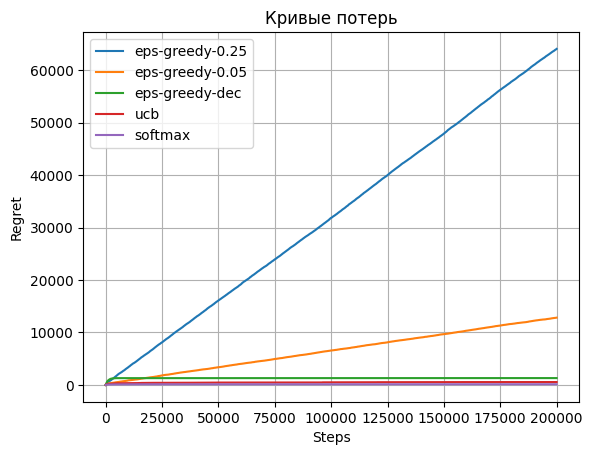

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
env = TenArmedBanditGaussian(seed=seed)
n_actions = env.action_space.n
n_trials = 200_000
xs = np.arange(n_trials+1)
eps_decay, ucb_const = .999, 2.
softmax_t_inv, softmax_t_decay=1.0, 0.33

# Evaluate and plot results for rand, eps-greedy, eps-greedy w/ decay and ucb agents
agent_random = Agent('rand', n_actions, seed, eps=1.)
agent_eps_greedy25 = Agent('eps-greedy-0.25', n_actions, seed, eps=0.25)
agent_eps_greedy5 = Agent('eps-greedy-0.05', n_actions, seed, eps=0.05)
agent_eps_greedy_decayed = Agent('eps-greedy-dec', n_actions, seed, eps=1.0, eps_decay=eps_decay)
agent_ucb = Agent('ucb', n_actions, seed, ucb_const=ucb_const)
agent_softmax = Agent('softmax', n_actions, seed, softmax_t_inv=softmax_t_inv, softmax_t_decay=softmax_t_decay)

agents = [
    # agent_random,
    agent_eps_greedy25,
    agent_eps_greedy5,
    agent_eps_greedy_decayed,
    agent_ucb,
    agent_softmax,
]

####### Здесь ваш код ########
cumulative_regrets = []

for agent in agents:
    env = TenArmedBanditGaussian(seed=seed)
    regrets = []
    cumulative_regret = 0

    for step in range(n_trials):
        action = agent.act()
        _, reward, _, _, info = env.step(action)
        agent.reinforce(action, reward)
        cumulative_regret += info['regret']
        regrets.append(cumulative_regret)

    cumulative_regrets.append(regrets)
    plt.plot(regrets, label=agent.name)

plt.xlabel('Steps')
plt.ylabel('Regret')
plt.title('Кривые потерь')
plt.grid(True)
##############################

plt.legend([agent.name for agent in agents])

## [Optional] Контекстные бандиты (Online Contextual Bandits)

### Описание задачи

Контекстные бандиты служат для решения проблемы, аналогичной многоруким бандитам, с той лишь разницей, что на каждой итерации выбора действия есть дополнительная информация.

Задача может быть описана итеративным процессом получения данных:

* На каждой итерации среда генерирует наблюдение, которое состоит из вектора признаков фиксированного размера, и значение вознаграждения, который является стохастичным, но зависит от первого вектора.

* Агент должен выбрать одно действие из множества действий ("рук") $m$.

* Среда сообщает вознаграждение для руки, которую выбрал агент.

Цель - построить стратегию, которая будет максимизировать вознаграждение, получаемое агентом.

Примерами сценариев использования могут быть задачи онлайн рекомендаций, в которых есть лишь информация о том, нажал ли пользователь на рекламную ссылку или нет, а информации про другие ссылки, на которые он нажал - нет.

Или задачи клинических испытаний, в которых мы знаем, как человек отреагировал на одно лекарство, но не знаем, как он отреагировал бы на другое.

###  Алгоритмы

В данном пункте мы частично рассмотрим библиотеку [Contextual Bandits](https://github.com/david-cortes/contextualbandits)

Библиотека предлагает реализации большого списка алгоритмов:

* Upper-confidence bounds: `BootstrappedUCB`, `LogisticUCB`, и `LinUCB`.

* Thompson sampling: `BootstrappedTS`, `LogisticTS`, `LinTS`, and `SoftmaxExplorer`.

* Greedy exploration: `EpsilonGreedy`

* Adaptive exploration: `AdaptiveGreedy`

Более полную информацию вы можете найти в [документации](https://contextual-bandits.readthedocs.io/en/latest/).
Также, обратите внимание на [примеры](https://github.com/david-cortes/contextualbandits/tree/master/example).


### Устанавливаем библиотеку и скачиваем данные

В данном случае используется датасет [Bibtex dataset](http://mlkd.csd.auth.gr/publication_details.asp?publicationID=278)  (см. _"Multilabel text classification for automated tag suggestion"_), содержащий теги, которые люди присвоили разным документам (цель - научиться предлагать теги на основе данных из этих документов). Скачать датасет можно на сайте: [Extreme Classification Repository](http://manikvarma.org/downloads/XC/XMLRepository.html).

In [15]:
!pip -q install contextualbandits

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [16]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B3lPMIHmG6vGcy1xM2pJZ09MMGM' -O bib.zip

--2025-11-16 14:12:42--  https://docs.google.com/uc?export=download&id=0B3lPMIHmG6vGcy1xM2pJZ09MMGM
Resolving docs.google.com (docs.google.com)... 74.125.137.139, 74.125.137.113, 74.125.137.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.137.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=0B3lPMIHmG6vGcy1xM2pJZ09MMGM&export=download [following]
--2025-11-16 14:12:42--  https://drive.usercontent.google.com/download?id=0B3lPMIHmG6vGcy1xM2pJZ09MMGM&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1149131 (1.1M) [application/octet-stream]
Saving to: ‘bib.zip’

bib.zip             100%[===================>]   1.10M  --.-KB/s    in 0.1s    

2025-11-16 1

In [17]:
!unzip bib.zip

Archive:  bib.zip
  inflating: Bibtex/Bibtex_data.txt  
  inflating: Bibtex/bibtex_trSplit.txt  
  inflating: Bibtex/bibtex_tstSplit.txt  


### Считываем данные

Данные представляют собой текстовый файл, используемый в libsvm и других системах, но с первой строкой, указывающей количество строк, столбцов и классов:

In [18]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data("Bibtex/Bibtex_data.txt")
print(X.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


## Пакетные модели

Логистическая регрессия и контекстный бандит:

In [19]:
from sklearn.linear_model import LogisticRegression

from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

nchoices = y.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)


## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior_ucb, percentile = 80,
                                   random_state = 1111)


models = [bootstrapped_ucb]

In [20]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb, *_ = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, ]

# batch size - algorithms will be refit after N rounds
batch_size = 50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)

# these lists will keep track of which actions does each policy choose
lst_a_ucb, *_ = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, ]

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)

    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')

    # keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())

    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)

    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist])

    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])

    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X, y,
                                             batch_st, batch_end)

### Визуализируем результаты

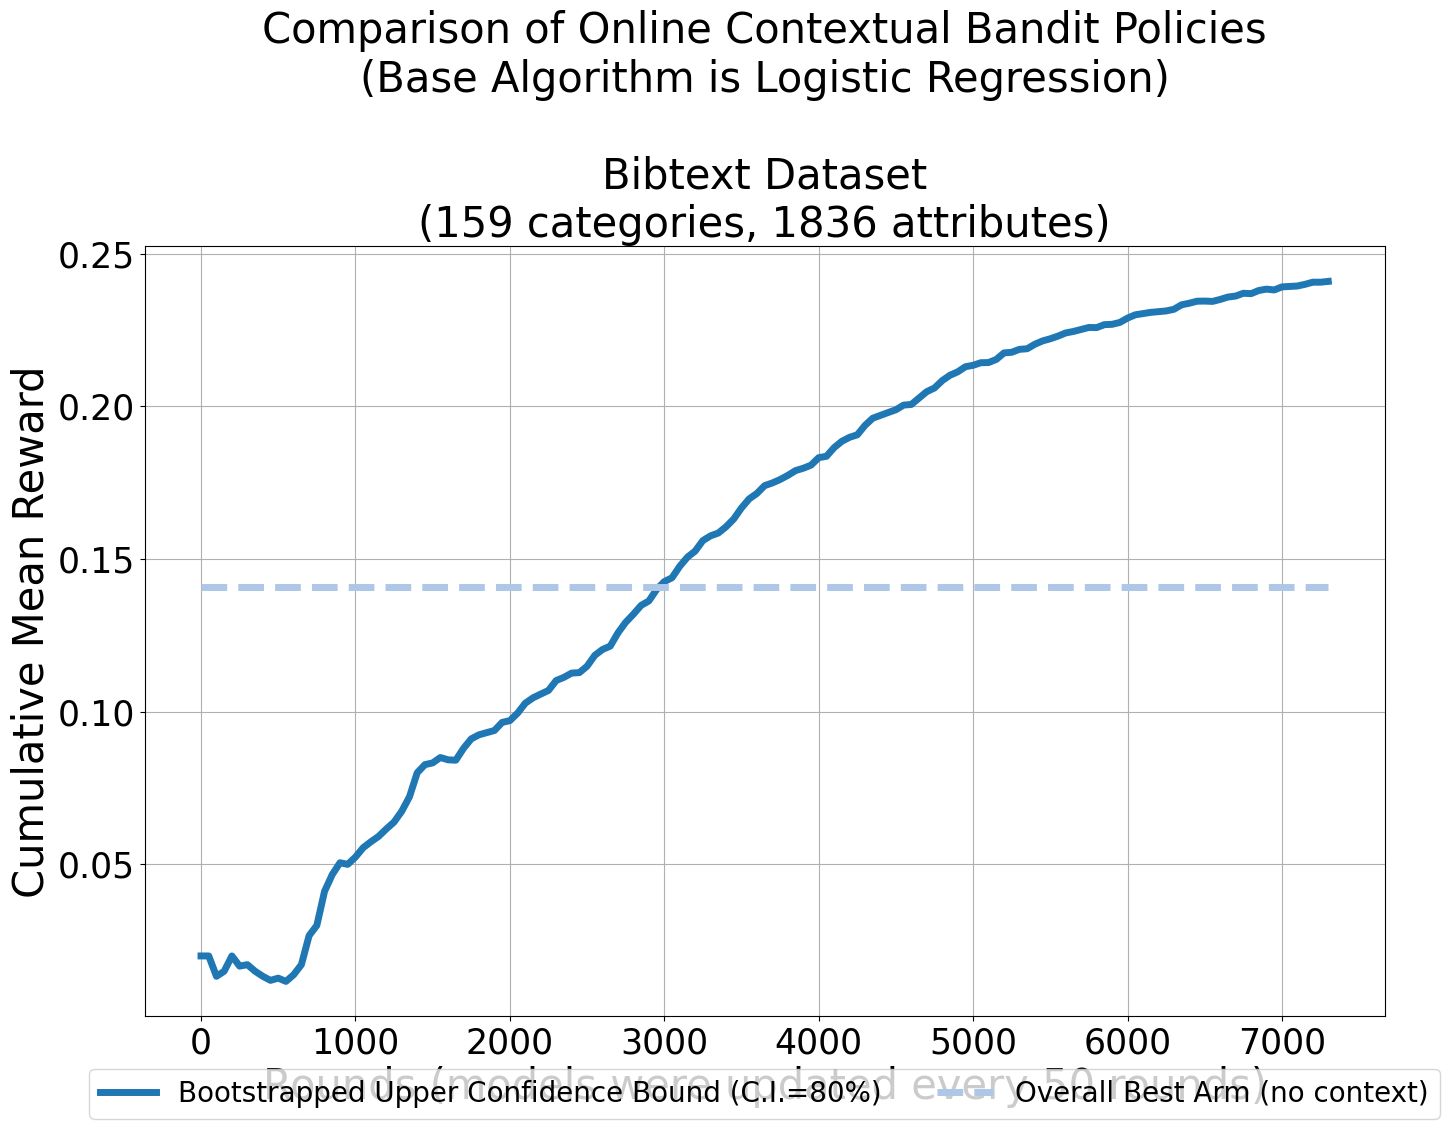

In [21]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 16, 8
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])

plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_ucb)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()